/Users/foxjap/jupyterNotebooks/hydroelectricity_forecast/hydro_dataset_fin.csv
/Users/foxjap/jupyterNotebooks/hydroelectricity_forecast/Forecast_Var_3_final.ipynb


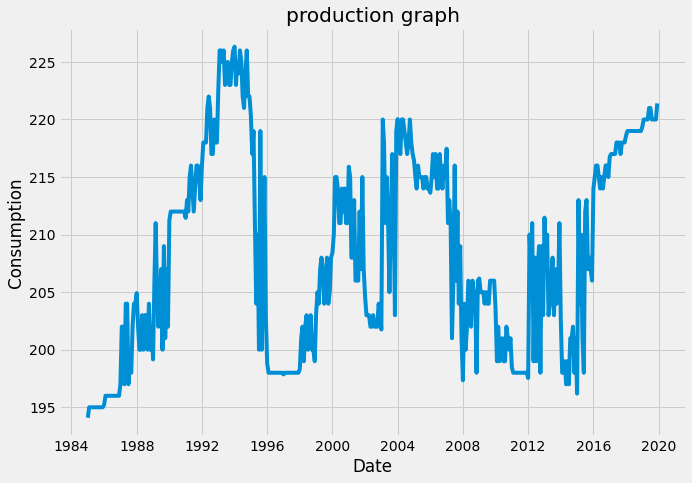

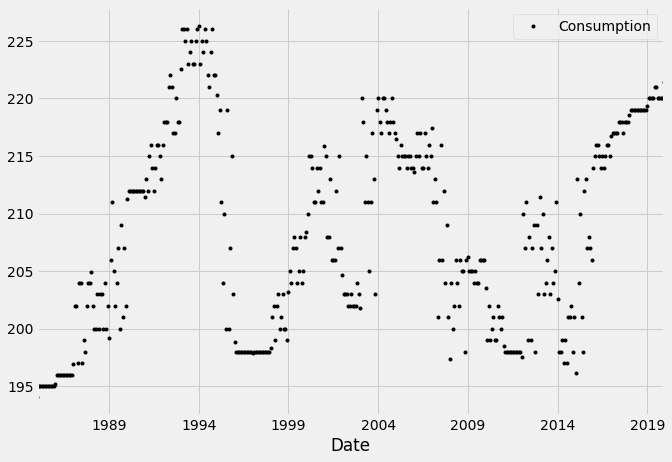

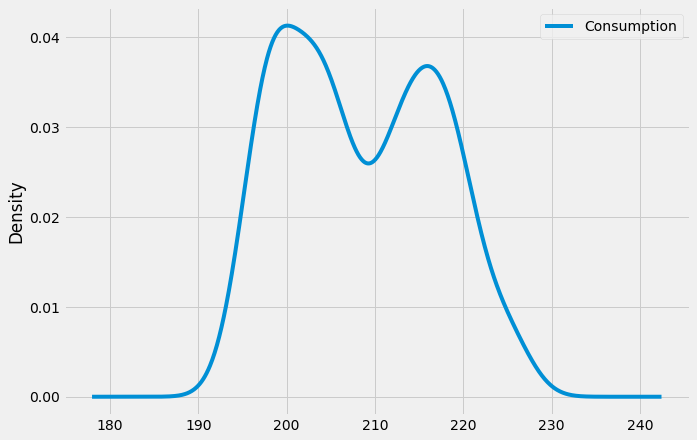

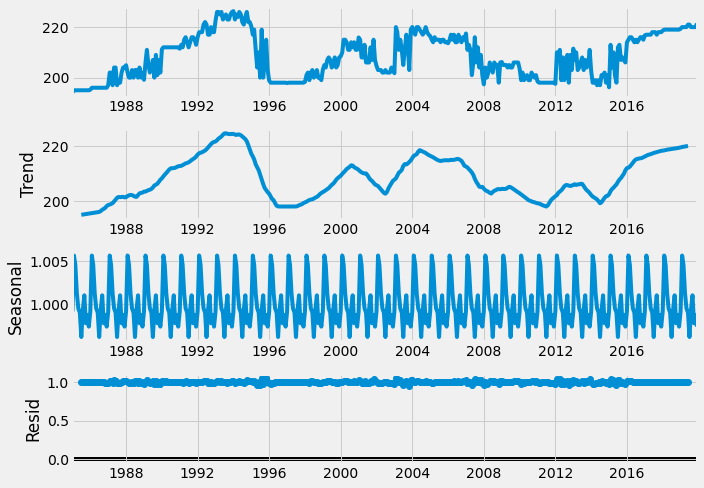

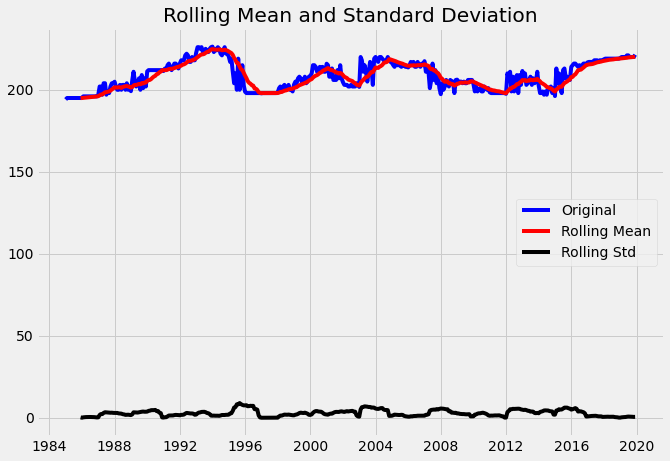

Results of dickey fuller test
Test Statistics                 -2.701391
p-value                          0.073798
No. of lags used                11.000000
Number of observations used    408.000000
critical value (1%)             -3.446480
critical value (5%)             -2.868650
critical value (10%)            -2.570557
dtype: float64


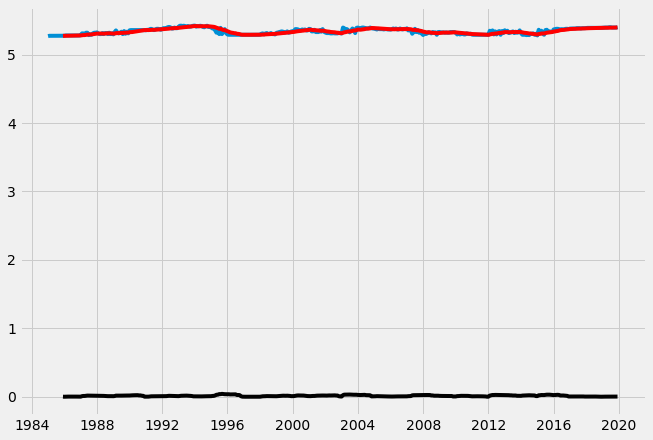

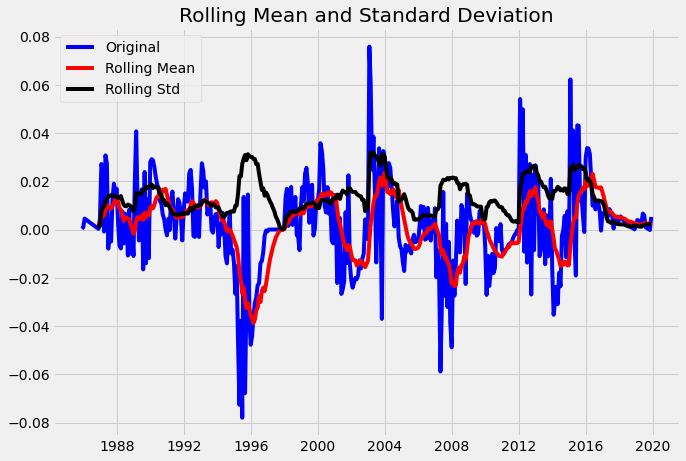

No handles with labels found to put in legend.


Results of dickey fuller test
Test Statistics               -6.115016e+00
p-value                        9.138818e-08
No. of lags used               2.000000e+00
Number of observations used    4.060000e+02
critical value (1%)           -3.446560e+00
critical value (5%)           -2.868685e+00
critical value (10%)          -2.570576e+00
dtype: float64


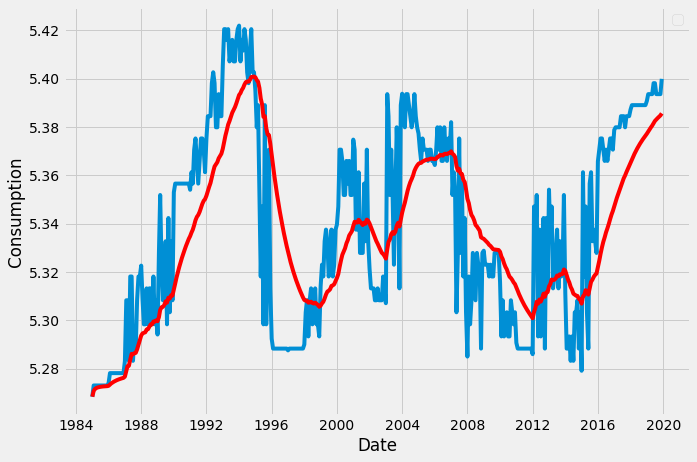

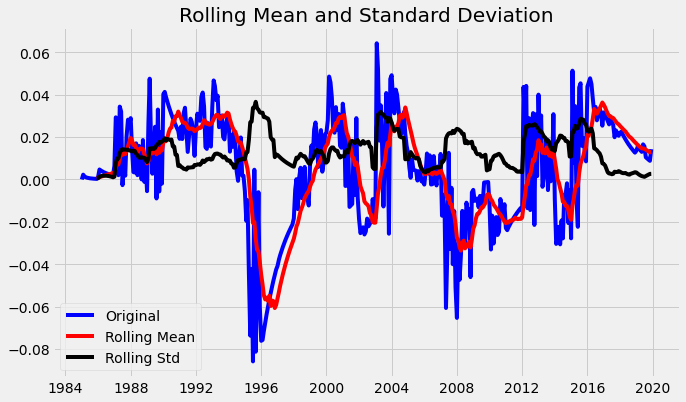

Results of dickey fuller test
Test Statistics                 -3.197825
p-value                          0.020111
No. of lags used                11.000000
Number of observations used    408.000000
critical value (1%)             -3.446480
critical value (5%)             -2.868650
critical value (10%)            -2.570557
dtype: float64


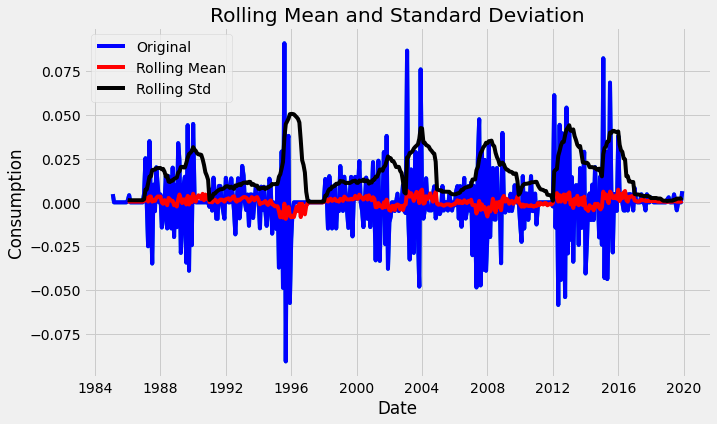

Results of dickey fuller test
Test Statistics                 -5.247896
p-value                          0.000007
No. of lags used                10.000000
Number of observations used    408.000000
critical value (1%)             -3.446480
critical value (5%)             -2.868650
critical value (10%)            -2.570557
dtype: float64


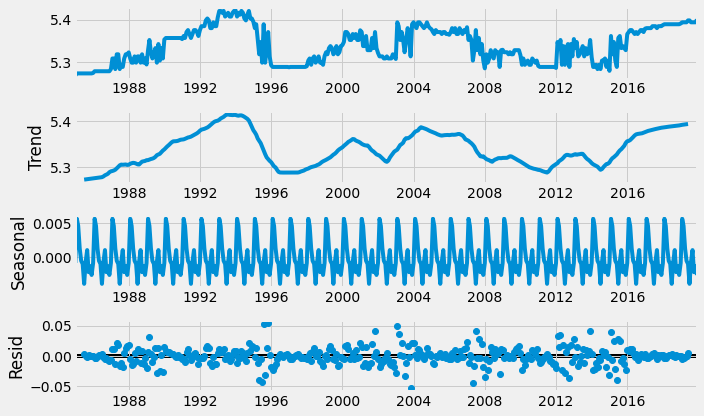

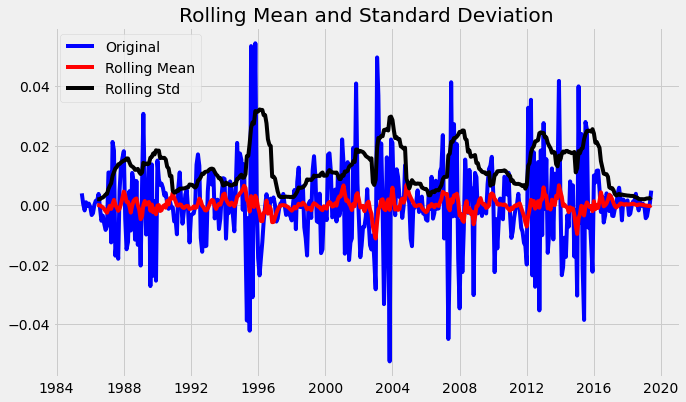

RSS : 0.114370


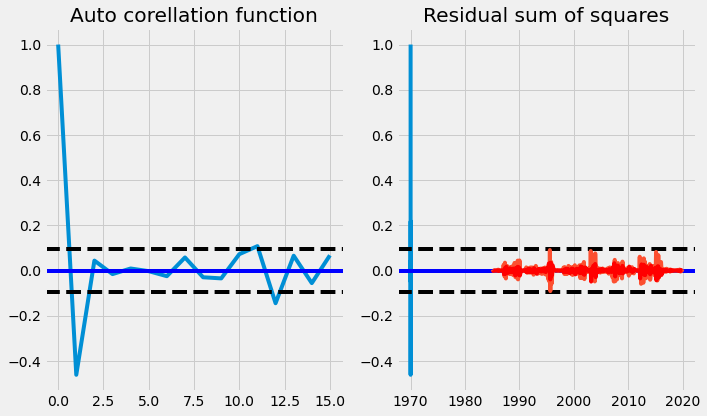

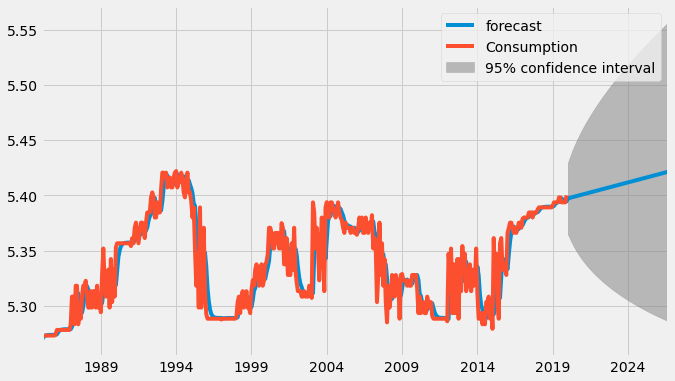

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import os
for dirname, _, filenames in os.walk('/Users/foxjap/jupyterNotebooks/hydroelectricity_forecast'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv('/Users/foxjap/jupyterNotebooks/hydroelectricity_forecast/hydro_test12345fin.csv')
df

df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

            # 1.Visualizing the time series.

plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

df.plot(style='k.')
plt.show()

df.plot(kind='kde')

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

            # 2. Stationarising the time series.

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df)

df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(df_log_moving_avg_diff)

weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
plt.legend()
plt.show(block =False)

logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

def test_stationarity_final(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)



trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity_final(residual)

        # 3. Finding the best parameters for our model

from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

        # 4. Fitting model

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,1)) # we can try (2,1,0), but (3,1,1) has less RSS
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("Residual sum of squares")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

        # 5. Predictions

result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=300)